# Kaggle Dataset - License Plate Detection

### Load in packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup 
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split



#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

## Read In, Clean, & Organize the Data

### Unzip files

In [ ]:
# upload file as zip, then use this command to unzip
!unzip car_data.zip

In [ ]:
images_list = ["Cars"+str(x)+".png" for x in range(0,433)]
annotations_list = ["Cars"+str(x)+".xml" for x in range(0,433)]

### Get annotations and change dimensions of bounding box

In [ ]:
# get all the anotations
bound_boxes = []        # [ymin,ymax,xmin,xmax]
set_image_height = 150
set_image_width = 150

for box in annotations_list:
  with open('car_data/annotations/{}'.format(box), 'r') as f:
    data = f.read() 
    # Passing the stored data inside the beautifulsoup parser 
    bs_data = BeautifulSoup(data, 'xml')
    
    # Find the width and height of each image
    h = int(bs_data.find('height').text)
    w = int(bs_data.find('width').text)

    # Finding all bounding box of tag   
    ymin = int(bs_data.find('ymin').text)
    ymax = int(bs_data.find('ymax').text)
    xmin = int(bs_data.find('xmin').text)
    xmax = int(bs_data.find('xmax').text)
    if h == set_image_height and w == set_image_width:
      bound_box = [ymin,ymax,xmin,xmax]
    else:
      rx = set_image_width/w
      ry = set_image_height/h
      bound_box = [ry*ymin,ry*ymax,rx*xmin,rx*xmax]
    bound_boxes.append(bound_box)

### Check out the data and the pre-annotated box

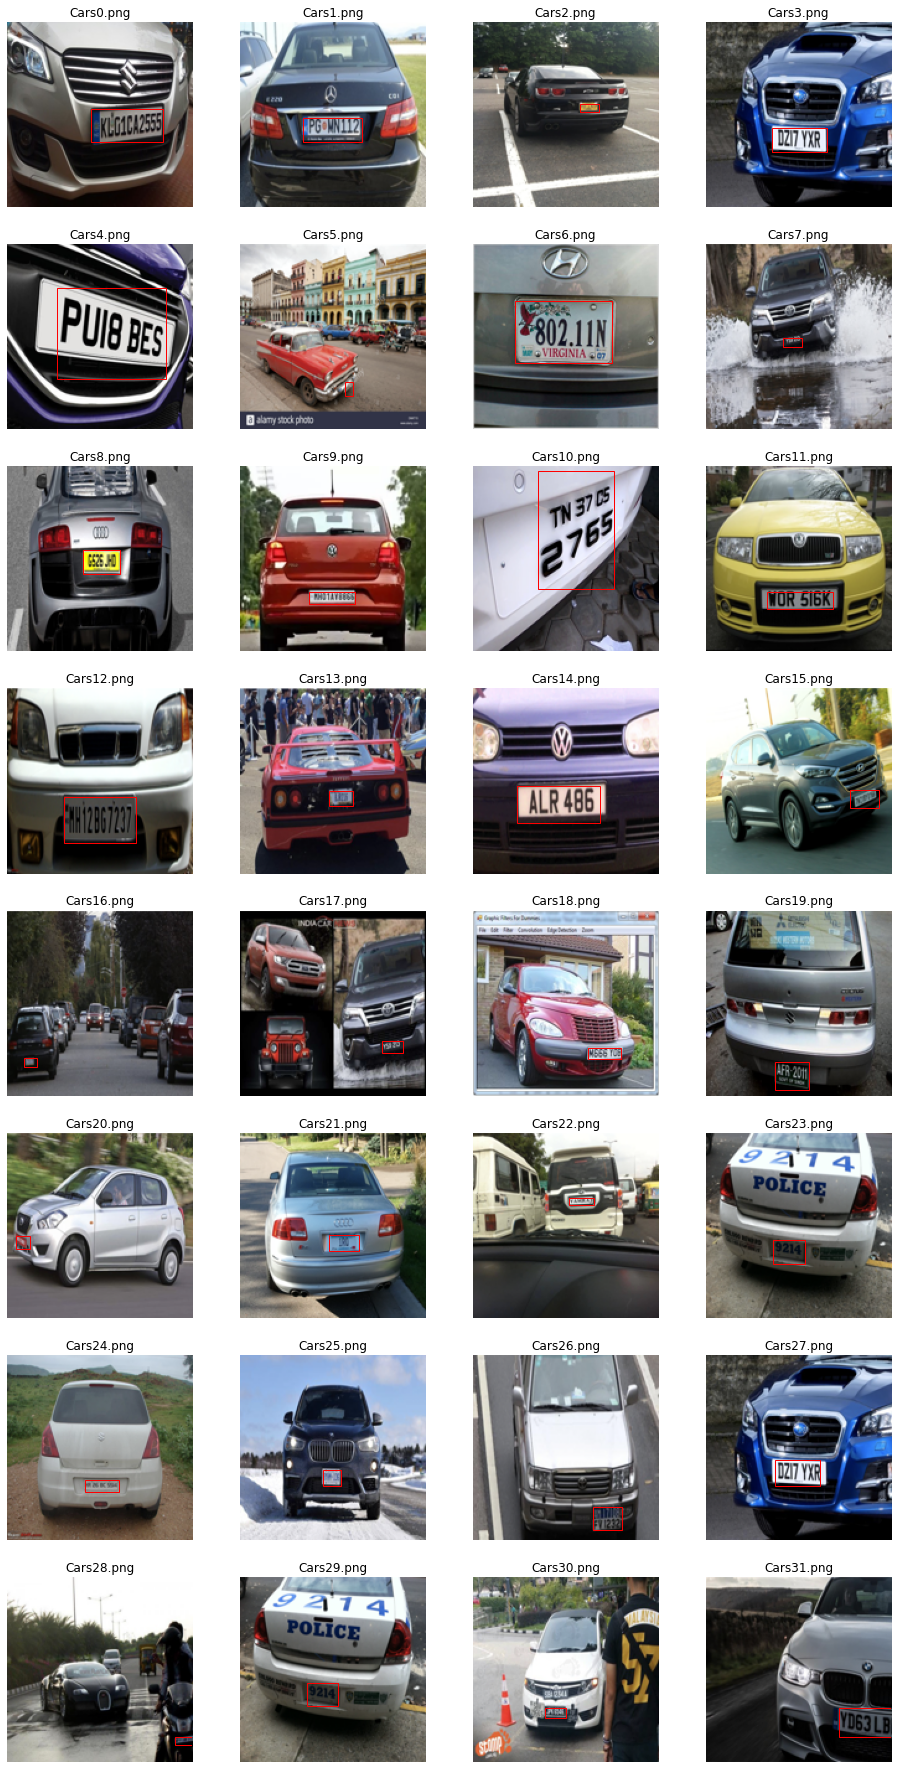

In [ ]:
# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for idx, image in enumerate(images_list[:32]):
  # load in image
  im = Image.open('car_data/images/Cars{}.png'.format(idx))
  # resize the image
  im = im.resize([set_image_height,set_image_width])
  # turn image into a numpy array
  imArray = np.array(im)
  # graph image and annotation box
  plt.subplot(n_rows, n_cols, idx + 1)
  plt.imshow(imArray)
  ax = plt.gca()
  plt.axis('off')
  plt.title(image, fontsize=12)
  # Create a Rectangle patch
  w = bound_boxes[idx][3]-bound_boxes[idx][2]
  h = bound_boxes[idx][1]-bound_boxes[idx][0]
  rect = patches.Rectangle((bound_boxes[idx][2], bound_boxes[idx][0]), w, h, linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

plt.subplots_adjust(wspace=.2, hspace=.2)

### Split data into test set and training

In [ ]:
indicies = range(433)
indicies
train, test = train_test_split(indicies, random_state=50)

## YOLO v5 Model

### New Version with [Roboflow](https://www.youtube.com/watch?v=rZyY2pNzypQ)

In [1]:
!git clone https://github.com/elc5tk/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
%pip install -q roboflow

Cloning into 'yolov5'...
remote: Enumerating objects: 13009, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 13009 (delta 0), reused 2 (delta 0), pack-reused 13006
Receiving objects: 100% (13009/13009), 11.92 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (9033/9033), done.
/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from roboflow import Roboflow
import os
import torch
from IPython.display import Image, clear_output
rf = Roboflow(model_format="yolov5", notebook="ultraytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultraytics


In [8]:
os.environ["DATASET_DIRECTORY"] = "/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/datasets"

In [49]:
rf = Roboflow(api_key="TqLqTYsqbqlJHnNuy2hm")
project = rf.workspace("kab7kr-virginia-edu").project("cars433")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /Users/kristybell/Desktop/MSDS/spring-semester


### Train the model

In [50]:
!python train.py --img 416 --batch 32 --epochs 120 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/datasets/Cars433-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=120, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/elc5tk/yolov5` to update.
YOLOv5 🚀 v6.1-163-g8e9c7f6 torch 1.11.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0,

### Training Results

In [51]:
# Start tensorboard
%load_ext tensorboard
%tensorboard  --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 64095), started 1 day, 6:10:47 ago. (Use '!kill 64095' to kill it.)

### Make predictions

In [61]:
!python detect.py --weights runs/train/exp3/weights/best.pt --img 416 --save-crop  --conf-thres 0.4 --line-thickness 2 --source {dataset.location}/valid/images

detect: weights=['runs/train/exp3/weights/best.pt'], source=/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/datasets/Cars433-2/valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-163-g8e9c7f6 torch 1.11.0 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/63 /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/datasets/Cars433-2/valid/images/Cars117_png.rf.80c5aaf5f63efa70e82dd5105d7372eb.jpg: 416x416 1 licence, Done. (0.280s)
image 2/63 /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/datasets/Cars433-2/valid/images/Cars12_png.rf.d4235beeaa51f19387e6b578e7067149.jpg: 416x416

## Show Test Images and Object Detection Bounding Boxes

- Final model trained on the 412x412 photos is saved in runs/train/exp3
- Final detections for the test data is in runs/detect/exp8

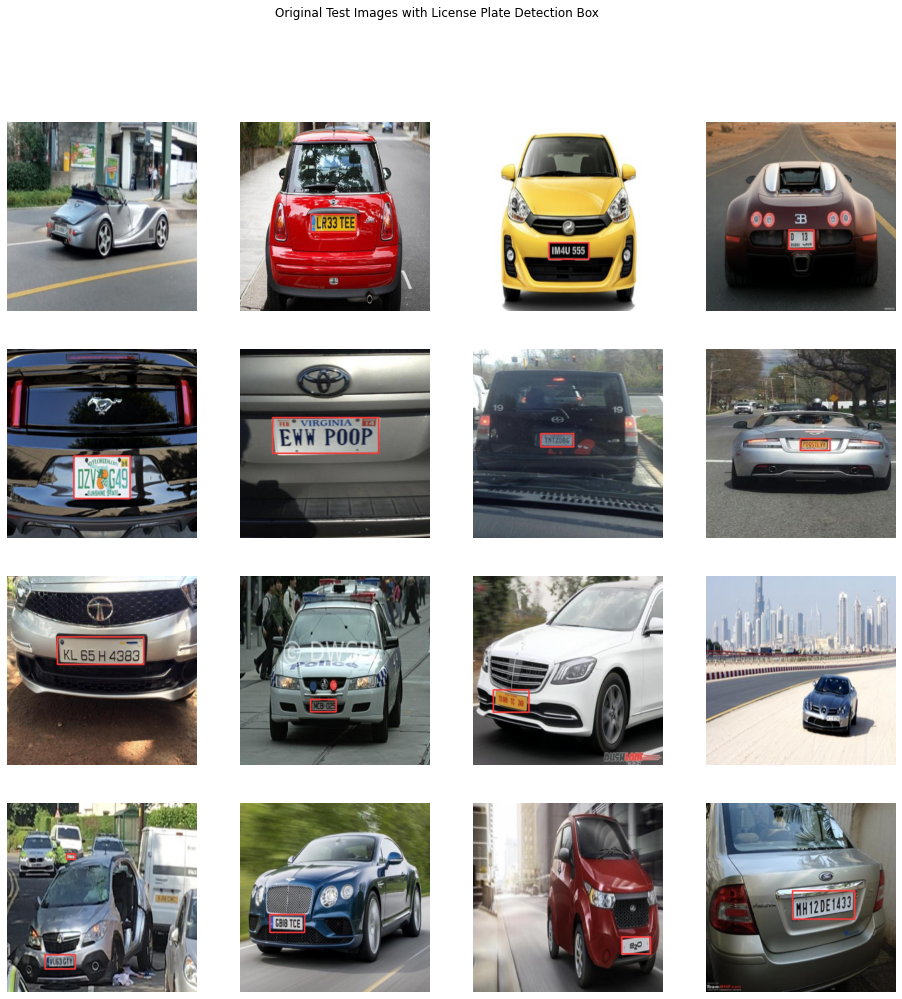

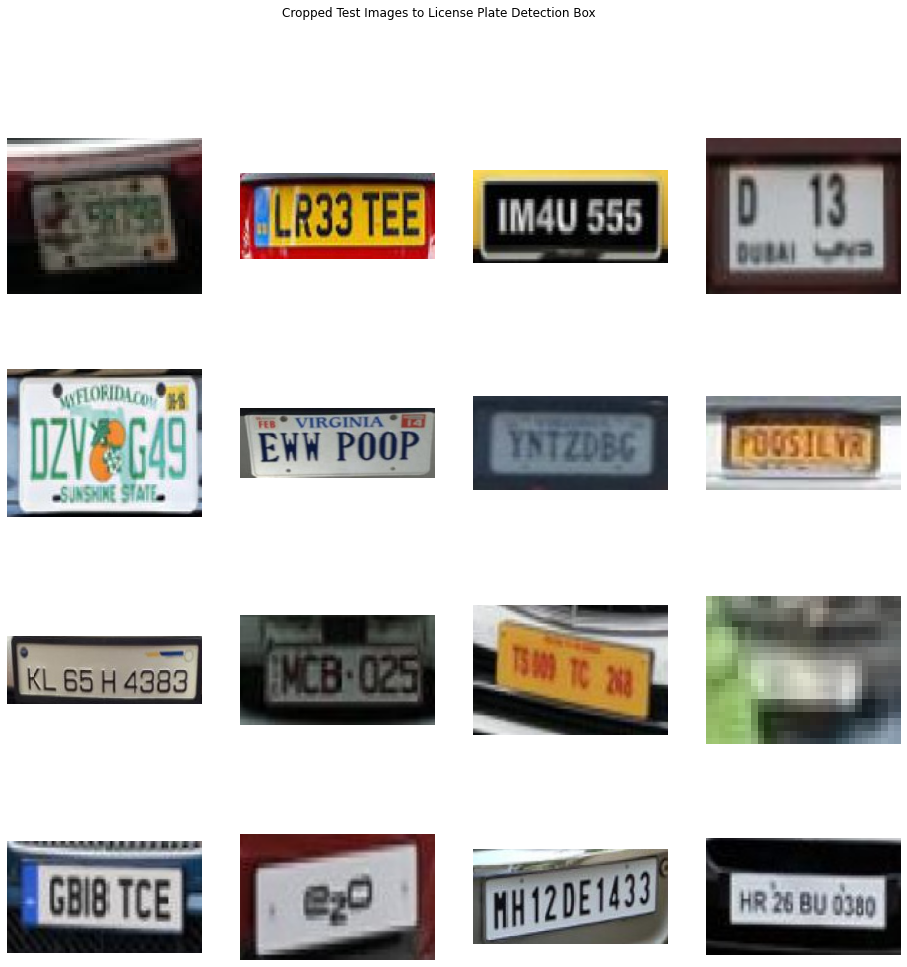

In [62]:
import glob
#from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np

# Rows and columns are set to fit one training batch (32)
n_rows = 4
n_cols = 4

# first plot 16 original test images
plt.figure(figsize=(n_cols * 4, n_rows * 4))

for idx, image in enumerate(glob.glob('/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/*.jpg')[:16]):
    # load in image
    im = Image.open(image)
    # make subplot
    # turn image into a numpy array
    imArray = np.array(im)
    # graph image and annotation box
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(imArray)
    ax = plt.gca()
    plt.axis('off')
plt.subplots_adjust(wspace=.2, hspace=.2)  
plt.suptitle("Original Test Images with License Plate Detection Box")
plt.show()
print("\n\n\n")

# first plot 16 original test images
plt.figure(figsize=(n_cols * 4, n_rows * 4))

for idx, image in enumerate(glob.glob('/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/*.jpg')[:16]):
    # load in image
    im = Image.open(image)
    # make subplot
    # turn image into a numpy array
    imArray = np.array(im)
    # graph image and annotation box
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(imArray)
    ax = plt.gca()
    plt.axis('off')
plt.subplots_adjust(wspace=.2, hspace=.2) 
plt.suptitle("Cropped Test Images to License Plate Detection Box")
plt.show()

### Use [Tesseract](https://tesseract-ocr.github.io/tessdoc/) for character recogition

In [ ]:
crops = [x for x in glob.glob('/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/*.jpg')] 

In [ ]:
with open('crop_names.txt', 'w') as f:
    for item in crops:
        f.write("%s\n" % item)

In [85]:
!tesseract /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/crop_names.txt /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/tess -l eng

Page 0 : /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/Cars47_png.rf.80acddbfc2856e44088741eb6523c3612.jpg
Estimating resolution as 350
Empty page!!
Estimating resolution as 350
Empty page!!
Page 1 : /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/Cars201_png.rf.d34c5c51dd755bd6bfc09d575815549e.jpg
Estimating resolution as 444
Empty page!!
Estimating resolution as 444
Empty page!!
Page 2 : /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/Cars328_png.rf.559a1ee0bbc1b5f9b8c5786baa896d36.jpg
Estimating resolution as 377
Page 3 : /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/Cars232_png.rf.ab8dd344290e3dc822303893817d0278.jpg
Page 4 : /Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/Cars392_png.rf.7ae022a4e64e7474106d7698e6950659.jpg
Estimating resolution as 523
Page 5 : 

In [116]:
f = open('/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/tess.txt', 'r')
data = f.read()
data

'\x0c\x0cIM4U 555\n\x0c\x0c\x0cEWW POOP\n\x0c\x0c\x0c° —KL 65H 4383\n\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0cALTE\n\x0c\x0c\x0c\x0c\x0c\x0c\x0caa\n\x0cG00) |\n\x0c\x0c\x0cH 04 BB S80\ncree)\n\x0c®RK=977AF)\n\x0c\x0c\x0cfpr ATE\n\x0cvin\n\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0ctT\nBOSS\n\x0c\x0c\x0c\x0cWe BOY\n\x0c\x0cmT\nHIDLYPH\n\x0c\x0cDANS4P.\n\x0c[ PaR P\n\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0cwre wT\n906090]\n\x0c‘\nVU63 CTY:——_—*\n\x0c\x0c\x0c\x0cALR 486\n\x0c'

In [120]:
data_into_list = data.replace('\x0c', '*').split("*")
print("Length of labels:", len(data_into_list))
print('Number of crops:', len(crops))
del data_into_list[-6] # remove weird index

Length of labels: 67
Number of crops: 66
Length of labels: 66


In [124]:
import re
final_tess_list = [re.sub('\n', '',x) for x in data_into_list]

### Use python version of tesseract

In [72]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract

Password:
sudo: a password is required
     |████████████████████████████████| 40 kB 3.8 MB/s  eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0


In [91]:
import pytesseract
pytess_preds = []
for i in crops:
    text = pytesseract.image_to_string(i, config='--psm 6')
    pytess_preds.append(text)
print(len(pytess_preds))

66


In [99]:
pytess_preds = [x.replace('\n','') for x in pytess_preds]

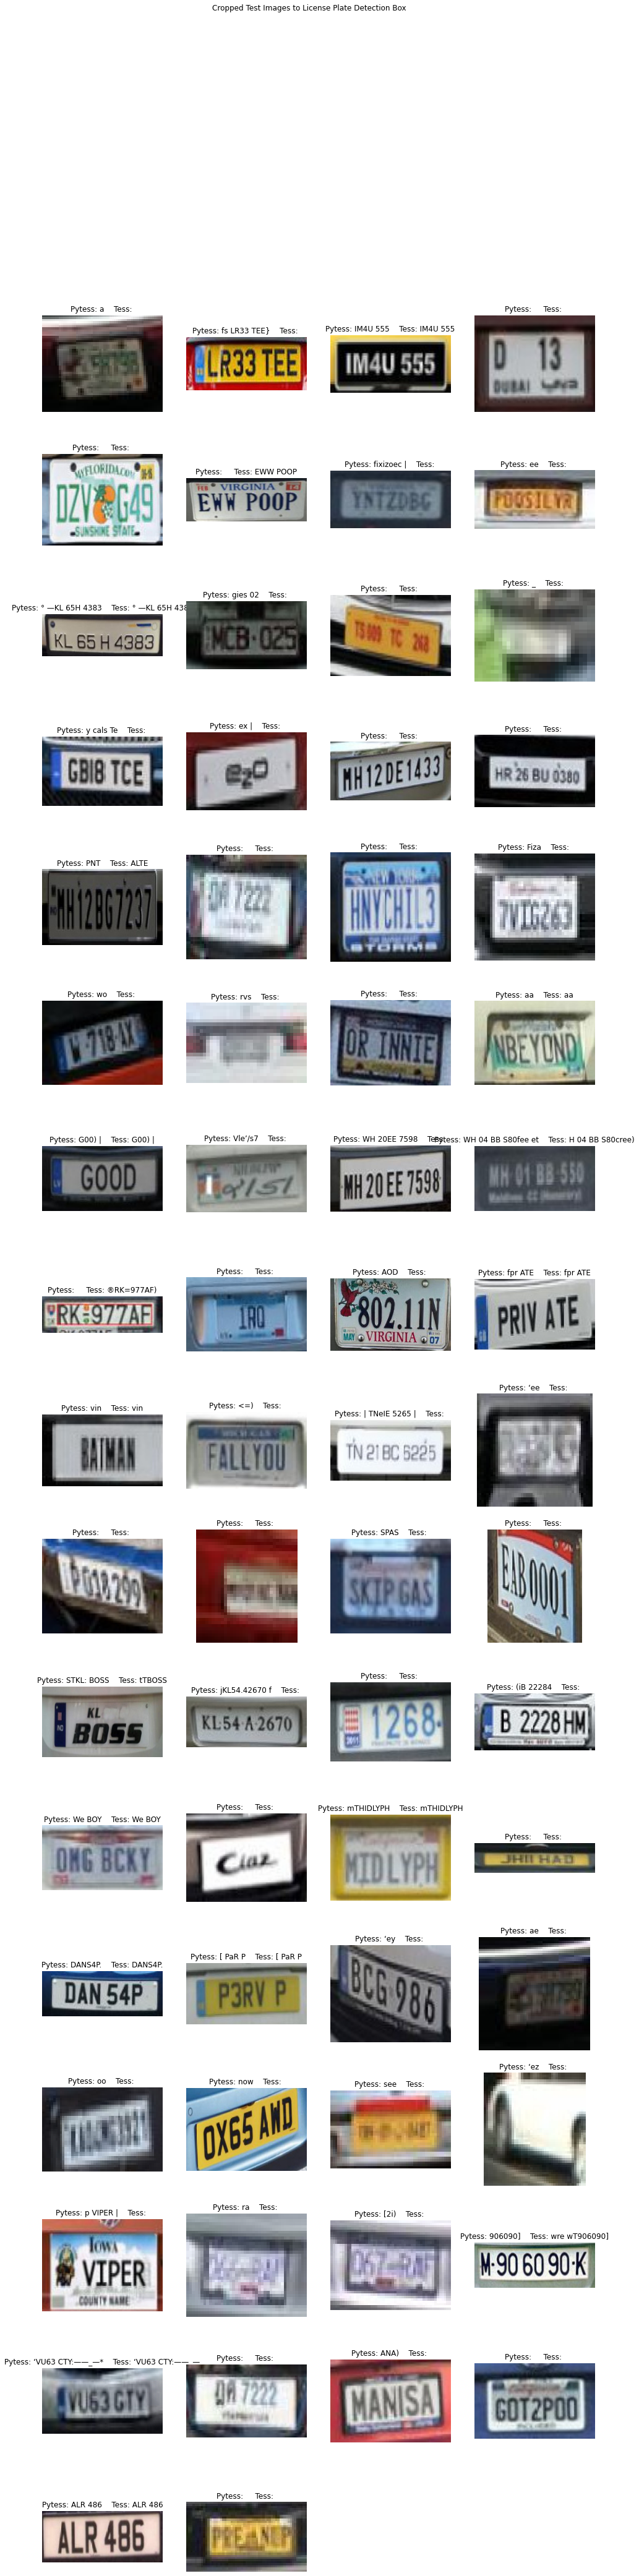

In [127]:
# first plot 16 original test images
n_rows = 17
n_cols = 4

# first plot 16 original test images
plt.figure(figsize=(n_cols * 4, n_rows * 4))


for idx, image in enumerate(glob.glob('/Users/kristybell/Desktop/MSDS/spring-semester/DS6050/yolov5/runs/detect/exp8/crops/licence/*.jpg')):
    # load in image
    im = Image.open(image)
    # make subplot
    # turn image into a numpy array
    imArray = np.array(im)
    # graph image and annotation box
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.title("Pytess: {}    Tess: {}".format(pytess_preds[idx], final_tess_list[idx]))
    plt.imshow(imArray)
    ax = plt.gca()
    plt.axis('off')
    
plt.subplots_adjust(wspace=.2, hspace=.2) 
plt.suptitle("Cropped Test Images to License Plate Detection Box")
plt.show()